<center>
<h1> SOLUCIÓN TAREA 10</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

Se usan dos imágenes, la primer es una foto de una calle con peatones y la segunda es una taza de café.

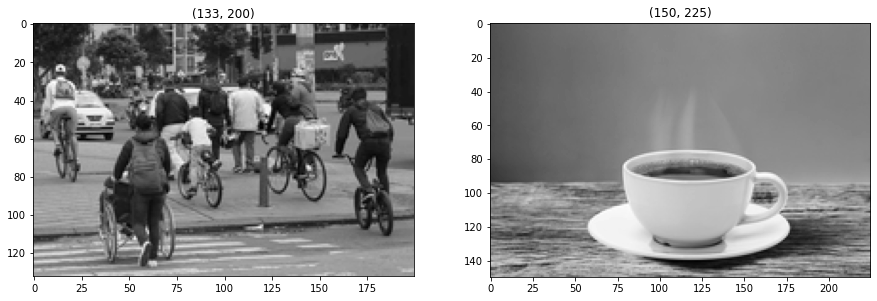

In [3]:
img = [cv.imread('fig/street.jpg', 0),
      cv.imread('fig/coffe.jpg',0)]
plt.figure(1, figsize=[15, 15*len(img)])
for n,i in enumerate(img):
    plt.subplot(1,len(img),n+1)
    plt.title(i.shape)
    plt.imshow(i, cmap='gray')

Se definen tres funciones fundamentales, en primer lugar la función pyramid genera una piramide donde se reduce la resolución a la mitad en cada nivel, la función parents retorna los posibles padres de cierta coordenada. La función relations selecciona entre los posibles padres al más cercano en nivel de gris para finalmente entregar el resultado a la función regions que propaga el valor de los pixeles del nivel más alto de la piramide a sus respectivos descendientes.

In [4]:
def pyramid(base, level):
    pyr=[]
    x=base.shape[0]
    y=base.shape[1]
    pyr.append(base)

    for i in range(level):
        if pyr[i].shape[1]<2 or pyr[i].shape[0]<2:
            break
        pyr.append(cv.pyrDown(pyr[i], dstsize=(pyr[i].shape[1]//2, pyr[i].shape[0]//2)))
    return pyr

def parents(x,y, parent):
    center=np.floor(np.array([np.floor(x/2)+x%2-0.5, np.floor(y/2)+y%2-0.5]))
    shape=parent.shape
    coor=[]
    color=[]
    
    for i in range(4):
        for j in range(4):
            point=center+np.array([i,j])
            if((point>=0).all()):
                if(point[0]<shape[0] and point[1]<shape[1]):
                    coor.append(point)
                    color.append(parent[int(point[0]), int(point[1])])
    return color, coor

def relations(child, parent):
    Csize=child.shape
    rel=np.zeros((Csize[0],Csize[1],2))
    for i in range(Csize[0]):
        for j in range(Csize[1]):
            parColor, parCoor = parents(i, j, parent)
            currPx = int(child[i,j])
            diff = [np.abs(x-currPx) for x in parColor]
            nearArg = np.argmin(diff)
            rel[i,j] = parCoor[nearArg]
    return rel

def regions(parent, relations, firstParent):
    x=relations.shape[0]
    y=relations.shape[1]
    segImg=np.zeros((x,y))
#     if firstParent==True:
#         print("isFirst")
#         pX=parent.shape[0]
#         pY=parent.shape[1]
#         nReg=pX*pY
#         regColor = np.linspace(0,254,nReg)
#         for c, n in zip(regColor, range(pX*pY)):
#             parent[n%pX, int((n-n%pX)/pX)]=c
    for i, x in enumerate(relations):
        for j, coor in enumerate(x):
            segImg[i,j]=parent[int(coor[0]), int(coor[1])]
    return segImg

A continuación se muestra la piramide de cinco niveles.

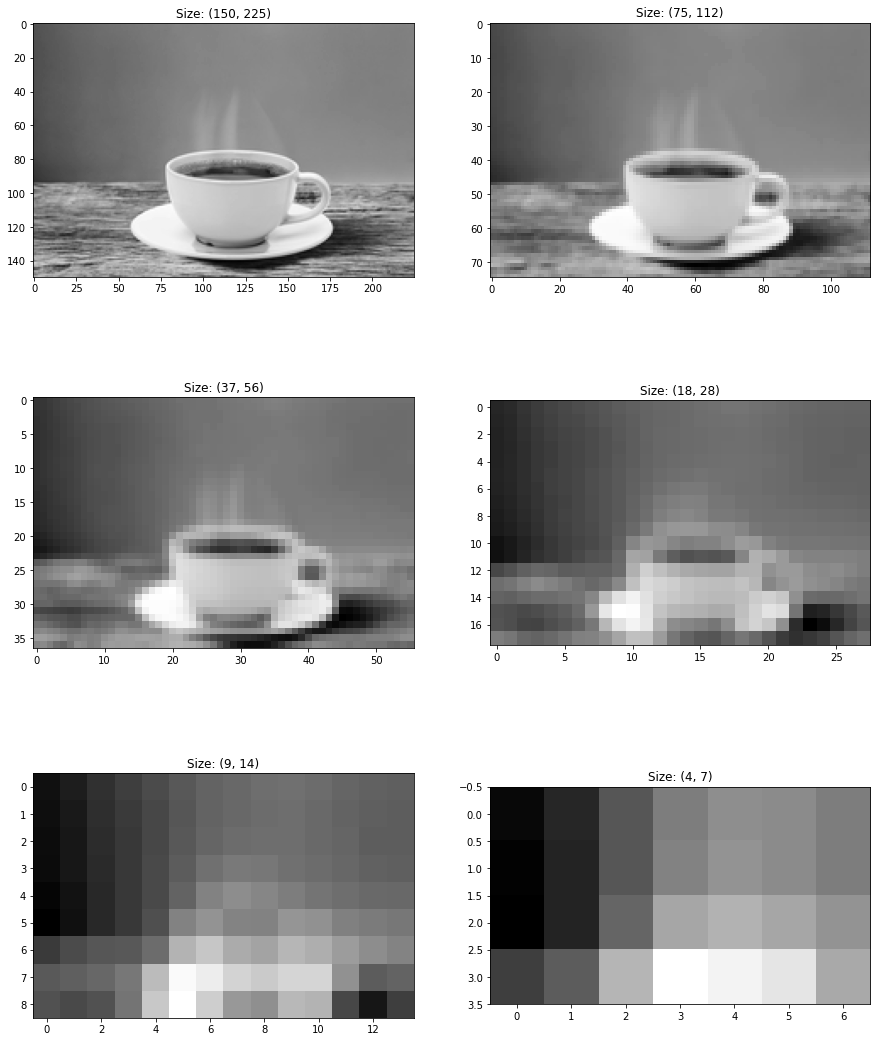

In [5]:
level=5
pyra=pyramid(img[1], level)
cont=1
plt.figure(2, figsize=[15,level*8])
for i in pyra:
    plt.subplot(level+1, 2, cont)
    plt.title("Size: " + str(i.shape))
    plt.imshow(i, cmap='gray')
    cont+=1

La función parents retorna los candidatos a padre de la posición (3,6), en este caso son los que están dentro de un cuadro de 4x4 pixeles más cercanos en la imagen de menor resolución.

In [6]:
pColor, pCoor = parents(3,6,pyra[4])
for col, coo in zip(pColor, pCoor):
    print("Color:", col, " Pos:", coo)

Color: 102  Pos: [1. 2.]
Color: 109  Pos: [1. 3.]
Color: 116  Pos: [1. 4.]
Color: 124  Pos: [1. 5.]
Color: 101  Pos: [2. 2.]
Color: 108  Pos: [2. 3.]
Color: 116  Pos: [2. 4.]
Color: 125  Pos: [2. 5.]
Color: 100  Pos: [3. 2.]
Color: 108  Pos: [3. 3.]
Color: 117  Pos: [3. 4.]
Color: 127  Pos: [3. 5.]
Color: 99  Pos: [4. 2.]
Color: 108  Pos: [4. 3.]
Color: 117  Pos: [4. 4.]
Color: 131  Pos: [4. 5.]


Los padres determinados en base al nivel de gris para el nivel cuatro se muestran a continuación.

In [7]:
reltest=relations(pyra[4],pyra[5])
print("Padres de la primera fila del nivel 4 \n", reltest[0])

Padres de la primera fila del nivel 4 
 [[2. 0.]
 [0. 0.]
 [0. 1.]
 [0. 2.]
 [0. 2.]
 [2. 2.]
 [0. 3.]
 [0. 5.]
 [0. 4.]
 [1. 4.]
 [0. 4.]
 [0. 6.]
 [0. 6.]
 [0. 6.]]


La función regions propaga el valor del padre mas cercano en escala de gris a los hijos, teniendo encuenta las relaciones entre ellos. Se puede ver como en el resultado las regiones son mas grandes y del color del padre correspondiente a esa zona.

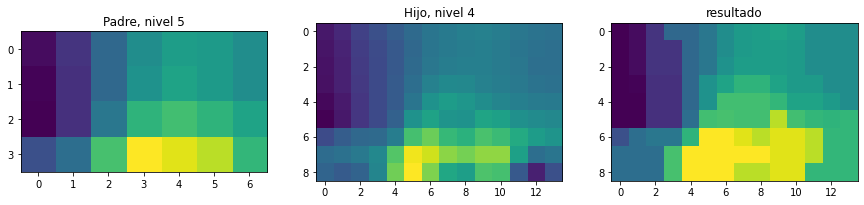

In [8]:
regTest=regions(pyra[5], reltest, False)
plt.figure(3, figsize=[15, 15*3])
plt.subplot(1,3,1)
plt.title("Padre, nivel 5")
plt.imshow(pyra[5])
plt.subplot(1,3,2)
plt.title("Hijo, nivel 4")
plt.imshow(pyra[4])
plt.subplot(1,3,3)
plt.title("resultado")
plt.imshow(regTest)

Finalmete usando todas las funciones anteriores se implementa pyrSegmentation que segmenta una imagen usando una piramide con la cantidad de niveles especificados.

In [9]:
def pyrSegmentation(image, level):
    pyr=pyramid(image, level)
    rel=[]
    for i in range(len(pyr)-1):
        rel.append(relations(pyr[i], pyr[i+1]))
    first=True
    seg=pyr[len(pyr)-1]
    for i in reversed(range(len(pyr))):
        if i==0:
            break
        seg=regions(seg, rel[i-1], first)
        first=False
    return seg

Se realiza la segmentación con las dos imagenes de prueba con diferentes niveles, se puede ver que al aumentar el número de niveles las reginones se hacen más grandes, esto debido a que el padre superior tiene menos pixeles y cada uno de ellos corresponden a las regiones que se propagan.
En ambos casos se puede ver como la segmentación separa cada una de las regiones, y les da un color uniforme.

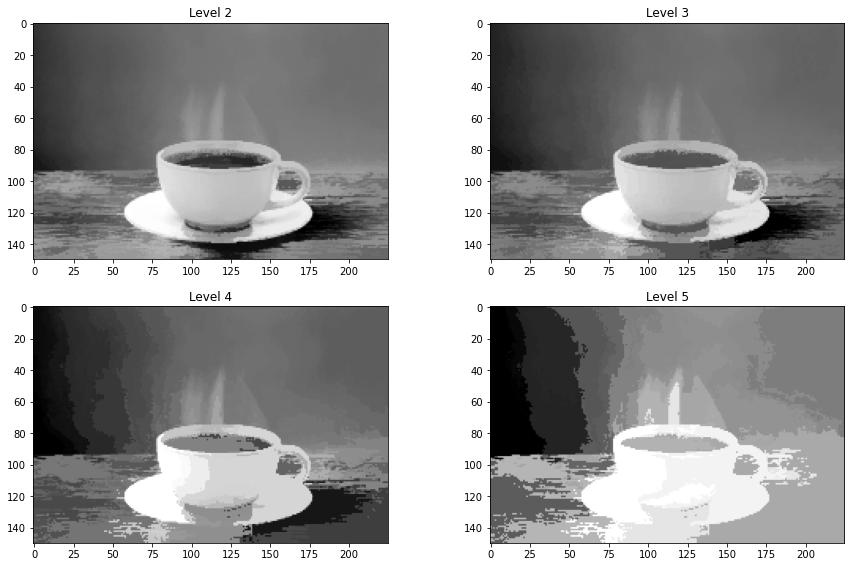

In [10]:
imgUt=img[1]
level=[2, 3, 4, 5]
plt.figure(4, figsize=[15,20])
for n, l in enumerate(level):
    seg=pyrSegmentation(imgUt, l)
    plt.subplot(len(level),2,n+1)
    plt.title("Level {}".format(l))
    plt.imshow(seg, cmap='gray')

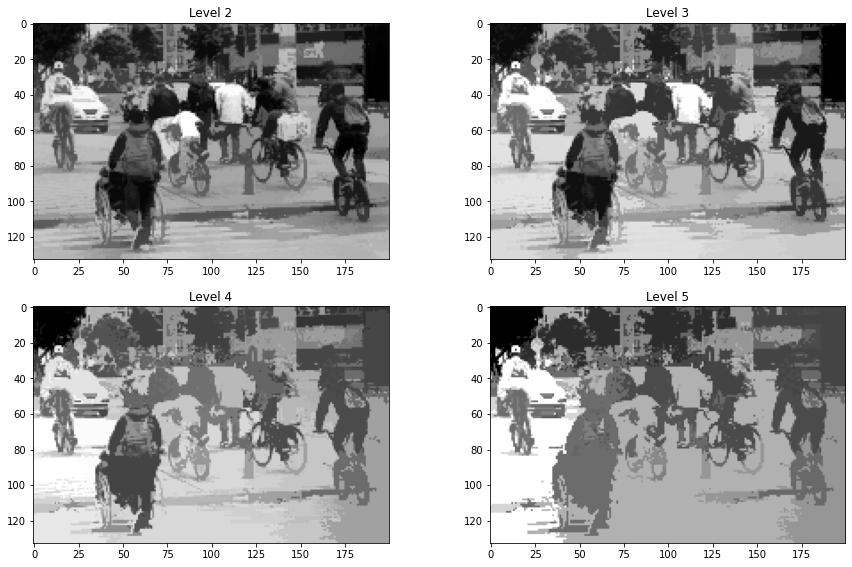

In [11]:
imgUt=img[0]
level=[2, 3, 4, 5]
plt.figure(4, figsize=[15,20])
for n, l in enumerate(level):
    seg=pyrSegmentation(imgUt, l)
    plt.subplot(len(level),2,n+1)
    plt.title("Level {}".format(l))
    plt.imshow(seg, cmap='gray')